<a href="https://colab.research.google.com/github/NitishMamadgi/DT_LSTM_prediction/blob/main/DT_training_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load training dataset
train_df = pd.read_csv('DT_training_dataset.csv')
train_df.head()

,ID,Event
0,116240628235930,Tiger
1,116240629000010,Tiger
2,116240629000055,Dragon
3,116240629000137,Dragon
4,116240629000219,Tiger


In [ ]:
label_encoder = LabelEncoder()
train_df['Event'] = label_encoder.fit_transform(train_df['Event'])

# Initialize lists to store sequences and next events
seq_length = 5
sequences = []
next_events = []

# Iterate through the dataframe to create sequences
for i in range(len(train_df) - seq_length):
    sequence = train_df['Event'].iloc[i:i + seq_length].values
    next_event = train_df['Event'].iloc[i + seq_length]
    sequences.append(sequence)
    next_events.append(next_event)

# Convert lists to numpy arrays
X_train = np.array(sequences)
y_train = np.array(next_events)

# Print the shape to visualize
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Save the modified dataset
modified_train_df = pd.DataFrame({'sequence': sequences, 'next_event': next_events})
modified_train_df.head()

X_train shape: (11100, 5), y_train shape: (11100,)


,sequence,next_event
0,"[2, 2, 0, 0, 2]",0
1,"[2, 0, 0, 2, 0]",2
2,"[0, 0, 2, 0, 2]",0
3,"[0, 2, 0, 2, 0]",0
4,"[2, 0, 2, 0, 0]",0


In [ ]:
# Define a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and dataloaders
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embeds = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(embeds, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Create dataset and dataloaders
train_dataset = MyDataset(X_train, y_train)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = len(label_encoder.classes_)  # Number of unique classes (Dragon, Tiger, Tie)
hidden_size = 50
num_layers = 2
output_size = len(label_encoder.classes_)  # Number of unique classes (Dragon, Tiger, Tie)
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
best_val_loss = float('inf')
early_stopping_patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'lstm_model.pth')
        print("Validation loss decreased, saving model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered")
            break

print("Training complete")

Epoch [1/20], Train Loss: 0.8031, Val Loss: 0.7644
Validation loss decreased, saving model
Epoch [2/20], Train Loss: 0.7715, Val Loss: 0.7637
Validation loss decreased, saving model
Epoch [3/20], Train Loss: 0.7707, Val Loss: 0.7688
Epoch [4/20], Train Loss: 0.7714, Val Loss: 0.7640
Epoch [5/20], Train Loss: 0.7709, Val Loss: 0.7671
Early stopping triggered
Training complete


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
test_df = pd.read_csv('DT_testing_dataset.csv')
test_df['Event'] = label_encoder.transform(test_df['Event'])
test_df.head()

,ID,Event
0,116240705235925,1
1,116240706000028,2
2,116240706000127,0
3,116240706000227,0
4,116240706000325,0


In [ ]:
# Convert dataframe to sequences of 10 events with the next event as output
sequences = []
next_events = []

for i in range(len(test_df) - seq_length):
    sequences.append(test_df['Event'].iloc[i:i + seq_length].values)
    next_events.append(test_df['Event'].iloc[i + seq_length])

X_test = np.array(sequences)
y_test = np.array(next_events)

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_test shape: (1204, 5), y_test shape: (1204,)


Test Loss: 0.7842, Test Accuracy: 50.75%

Classification Report:
              precision    recall  f1-score   support

      Dragon       0.50      0.61      0.55       576
         Tie       0.00      0.00      0.00        27
       Tiger       0.53      0.43      0.47       601

    accuracy                           0.51      1204
   macro avg       0.34      0.35      0.34      1204
weighted avg       0.50      0.51      0.50      1204



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


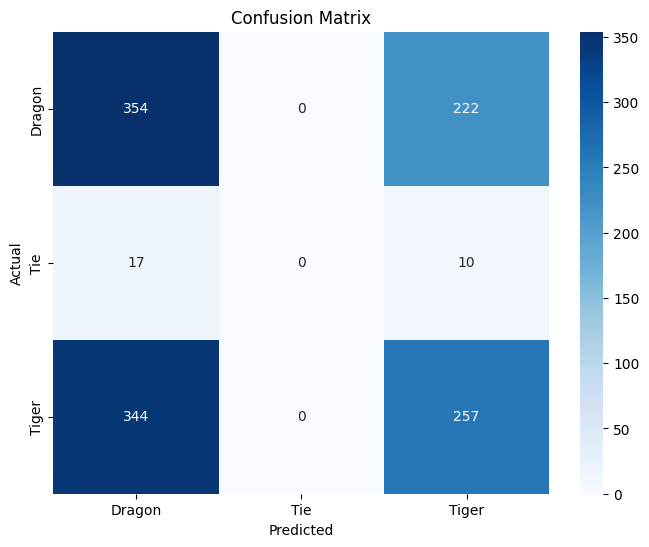

In [ ]:
# Create test dataloader
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the trained model
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()

# Evaluate the model
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()